In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path1 = "/content/drive/MyDrive/Current Workspace/Pattern Recognition/x_train.npy"  # x_train
path2 = "/content/drive/MyDrive/Current Workspace/Pattern Recognition/y_train.npy"  # y_train
path3 = "/content/drive/MyDrive/Current Workspace/Pattern Recognition/x_test.npy"  # x_test
path4 = "/content/drive/MyDrive/Current Workspace/Pattern Recognition/y_test.npy"  # y_test
LOAD_WEIGHT_PATH = "/content/drive/MyDrive/Current Workspace/Pattern Recognition/resnet152_wt.pth"

In [3]:
from sklearn.metrics import accuracy_score
from PIL import Image
import copy
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torchvision
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load data

In [5]:
x_train = np.load(path1)
y_train = np.load(path2)
y_train = y_train.reshape(len(y_train))

x_test = np.load(path3)
y_test = np.load(path4)
y_test = y_test.reshape(len(y_test))

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [6]:
# It's a multi-class classification problem
class_index = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,
               'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


![image](https://img-blog.csdnimg.cn/20190623084800880.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3lqcDE5ODcxMDEz,size_16,color_FFFFFF,t_70)

0


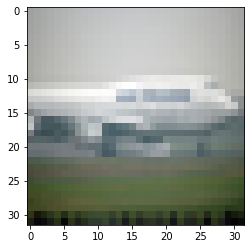

In [7]:
i = 100
plt.imshow(x_train[i])
print(y_train[i])

In [8]:
print(x_train[0].shape)

(32, 32, 3)


## Data preprocess

In [9]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.Resize((256, 256)),
        # transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

img = Image.fromarray(x_train[100])
tmp = data_transforms['train'](img)

In [10]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        X = self.X[index]

        if self.transform:
            X = self.transform(Image.fromarray(X))

        y = self.y[index]

        return X, y

    def __len__(self):
        return self.y.shape[0]

In [11]:
# split dataset
datasets = {}
train_size = 47000

datasets['train'] = CustomDataset(
    x_train[:train_size], y_train[:train_size], data_transforms['train'])
datasets['val'] = CustomDataset(
    x_train[train_size:], y_train[train_size:], data_transforms['val'])
datasets['test'] = CustomDataset(x_test, y_test, data_transforms['test'])

In [12]:
# show image in datasets
tmp_x, tmp_y = datasets['train'][1000]
#print(tmp_y)
# plt.imshow(tmp_x.permute(1, 2, 0))

In [13]:
dataloaders = {x: DataLoader(datasets[x], batch_size=512, shuffle=True)
               for x in ['train', 'val']}
dataloaders['test'] = DataLoader(
    datasets['test'], batch_size=2000, shuffle=False)
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}
class_names = ['airplane', 'automobile', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
print(dataset_sizes['train'])
print(dataset_sizes['val'])
print(dataset_sizes['test'])

47000
3000
10000


## Performance

### DO NOT MODIFY CODE BELOW!
**Please screen shot your results and post it on your report**

In [15]:
def predict(model):
    model.eval()
    y_pred = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            del inputs
            del labels
            torch.cuda.empty_cache()

            y_pred.extend(preds.tolist())
    return np.array(y_pred)

In [16]:
model = torchvision.models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)
model.load_state_dict(torch.load(LOAD_WEIGHT_PATH))

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

<All keys matched successfully>

In [17]:
y_pred = predict(model)
print(y_pred)

[1 5 3 ... 8 8 1]


In [18]:
assert y_pred.shape == (10000,)

In [19]:
y_test = np.load(path4)
y_test = y_test.reshape(len(y_test))
print("Accuracy of my model on test set: ", accuracy_score(y_test, y_pred))

Accuracy of my model on test set:  0.8739
